# Лабораторная работа № 5
### Шубина София НПИбд-02-23

Задача: имеются данные о поведении клиентов и расторжении договоров с банком, содержащие следующие сведения:

RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата
Exited — факт ухода клиента

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score

In [7]:
# загружаем данные
data = pd.read_csv('Churn_Modelling.csv')
data.info()
print(data.isnull().sum())

# удаляем неинформативные столбцы и перезаписываем data
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
print("\nПосле удаления столбцов:")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography 

Категориальные признаки 'Geography' и 'Gender' успешно преобразованы в числовой формат с помощью OrdinalEncoder. Для признака 'Geography' странам присвоены коды: France → 0, Germany → 1, Spain → 2. Для признака 'Gender' значения закодированы как: Female → 0, Male → 1. Теперь все признаки в данных являются числовыми и готовы для дальнейшего анализа и построения моделей машинного обучения.

In [9]:
category_columns = ['Geography', 'Gender']
encoder = OrdinalEncoder()
data[category_columns] = encoder.fit_transform(data[category_columns])  # Исправлено на data

# Проверяем результат
print("Категориальные признаки после кодирования:")
print(data[category_columns].head())
print(f"\nУникальные значения:")
for col in category_columns:
    print(f"{col}: {sorted(data[col].unique())}")

Категориальные признаки после кодирования:
   Geography  Gender
0        0.0     0.0
1        2.0     0.0
2        0.0     0.0
3        0.0     0.0
4        2.0     0.0

Уникальные значения:
Geography: [np.float64(0.0), np.float64(1.0), np.float64(2.0)]
Gender: [np.float64(0.0), np.float64(1.0)]


In [10]:
# сформируем признаки и целевой показатель
target = data['Exited']
features = data.drop('Exited', axis=1)
RANDOM_STATE = 42

Дисбаланс классов составляет примерно 1:4. Это означает, что на каждого ушедшего клиента (класс 1) приходится около 4 оставшихся клиентов (класс 0). Такое соотношение 0.25 указывает на значительный дисбаланс в данных, где отрицательный класс (клиенты которые остались) преобладает над положительным (клиенты которые ушли), что требует применения специальных методов для коррекции дисбаланса при построении модели.

In [11]:
# проверим дисбаланс классов
class_zero = target[target == 0].count()
class_one =  target[target == 1].count()
print('Соотношение классов:', class_one/class_zero)

Соотношение классов: 0.25580811252040686


In [12]:
# разделим данные на обучащую и тестовые выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=RANDOM_STATE, stratify=target)

Выполняем стандартизацию числовых признаков с помощью StandardScaler. Масштабатор обучается на тренировочных данных, преобразуя признаки к распределению со средним 0 и стандартным отклонением 1, затем применяется к тестовой выборке без переобучения для сохранения согласованности. После преобразования выводятся размеры выборок, примеры данных, описательная статистика и проверка корректности масштабирования через средние значения и стандартные отклонения, которые должны быть близки к 0 и 1 соответственно.

In [15]:
# Создаем объект масштабатора
scaler = StandardScaler()

# Определяем числовые столбцы для масштабирования
numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Создаем копии данных для масштабированных версий
features_train_scaled = features_train.copy()
features_test_scaled = features_test.copy()

# Масштабируем числовые признаки
# Обучаем на тренировочных данных и преобразуем обе выборки
features_train_scaled[numeric_columns] = scaler.fit_transform(features_train[numeric_columns])
features_test_scaled[numeric_columns] = scaler.transform(features_test[numeric_columns])

print("Масштабирование завершено!")
print(f"Размер обучающей выборки: {features_train_scaled.shape}")
print(f"Размер тестовой выборки: {features_test_scaled.shape}")

print("\nПервые 5 строк масштабированной обучающей выборки:")
print(features_train_scaled[numeric_columns].head().round(3))

print("\nСтатистика после масштабирования (обучающая выборка):")
print(features_train_scaled[numeric_columns].describe().round(3))

# Проверяем, что среднее ~0 и стандартное отклонение ~1
print("\nПроверка масштабирования (средние значения):")
print(features_train_scaled[numeric_columns].mean().round(6))

print("\nПроверка масштабирования (стандартные отклонения):")
print(features_train_scaled[numeric_columns].std().round(6))

Масштабирование завершено!
Размер обучающей выборки: (8000, 10)
Размер тестовой выборки: (2000, 10)

Первые 5 строк масштабированной обучающей выборки:
      CreditScore    Age  Tenure  Balance  NumOfProducts  EstimatedSalary
2151        1.059  1.715   0.685   -1.226         -0.910            1.042
8392        0.914 -0.660  -0.696    0.413         -0.910           -0.624
5006        1.079 -0.185  -1.732    0.602          0.809            0.308
4117       -0.929 -0.185  -0.006   -1.226          0.809           -0.290
7182        0.427  0.955   0.339    0.548          0.809            0.135

Статистика после масштабирования (обучающая выборка):
       CreditScore       Age    Tenure   Balance  NumOfProducts  \
count     8000.000  8000.000  8000.000  8000.000       8000.000   
mean        -0.000     0.000    -0.000     0.000         -0.000   
std          1.000     1.000     1.000     1.000          1.000   
min         -3.114    -1.990    -1.732    -1.226         -0.910   
25%         -0

In [18]:
# Обучение модели
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_train_scaled, target_train)

# Прогноз и метрики
predictions = model.predict(features_test_scaled)
f1 = f1_score(target_test, predictions)
accuracy = model.score(features_test_scaled, target_test)

print("Результаты логистической регрессии:")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Матрица ошибок
cm = confusion_matrix(target_test, predictions)
print(f"\nМатрица ошибок:")
print("     Предсказано")
print("      0     1")
print(f"0   {cm[0,0]:>4}  {cm[0,1]:>4}")
print(f"1   {cm[1,0]:>4}  {cm[1,1]:>4}")

# Быстрый анализ матрицы ошибок
tn, fp, fn, tp = cm.ravel()
print(f"\nАнализ:")
print(f"Правильно предсказанные: {tp + tn} ({((tp + tn) / cm.sum() * 100):.1f}%)")
print(f"Ошибки I рода (False Positive): {fp}")
print(f"Ошибки II рода (False Negative): {fn}")

Результаты логистической регрессии:
F1-score: 0.2292
Accuracy: 0.8050

Матрица ошибок:
     Предсказано
      0     1
0   1552    41
1    349    58

Анализ:
Правильно предсказанные: 1610 (80.5%)
Ошибки I рода (False Positive): 41
Ошибки II рода (False Negative): 349


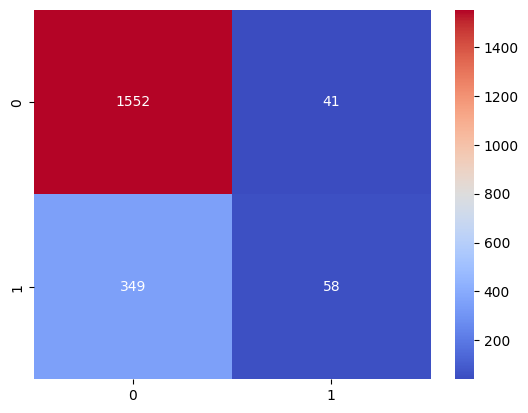

In [19]:
#построим матрицу ошибок
sb.heatmap(confusion_matrix(target_test, predictions), 
           annot=True, fmt=".10g", cmap= 'coolwarm')
plt.show()

Эта функция выполняет даунсэмплинг — метод балансировки несбалансированных данных путём уменьшения количества примеров мажоритарного класса. Сначала она разделяет данные на два класса: мажоритарный (класс 0) и миноритарный (класс 1). Затем автоматически вычисляет долю выборки мажоритарного класса, необходимую для балансировки, либо использует переданное значение fraction. После этого функция случайным образом отбирает рассчитанное количество примеров из мажоритарного класса и объединяет их с полным набором примеров миноритарного класса. На завершающем этапе данные перемешиваются для устранения возможного влияния порядка записей. В результате возвращается сбалансированный набор данных, что способствует улучшению качества обучения моделей машинного обучения на несбалансированных выборках.

In [23]:
def downsample(features, target, fraction=None, random_state=42):
    """
    Уменьшает количество примеров мажоритарного класса для балансировки данных
    
    Parameters:
    features - признаки
    target - целевая переменная
    fraction - доля мажоритарного класса для сохранения (от 0 до 1)
               если None, балансирует классы до равного количества
    random_state - случайное состояние для воспроизводимости
    
    Returns:
    features_downsampled - сбалансированные признаки
    target_downsampled - сбалансированная целевая переменная
    """
    
    # Разделяем данные по классам
    features_zeros = features[target == 0]  # Мажоритарный класс
    features_ones = features[target == 1]   # Миноритарный класс
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    print(f"Исходное распределение:")
    print(f"Класс 0: {len(features_zeros)} примеров")
    print(f"Класс 1: {len(features_ones)} примеров")
    print(f"Соотношение: {len(features_zeros)}:{len(features_ones)}")
    
    # Автоматическая балансировка до равного количества
    if fraction is None:
        fraction = len(features_ones) / len(features_zeros)
        print(f"\nАвтоматическая балансировка: fraction = {fraction:.3f}")
    
    # Уменьшаем мажоритарный класс
    features_zeros_down = features_zeros.sample(frac=fraction, random_state=random_state)
    target_zeros_down = target_zeros.sample(frac=fraction, random_state=random_state)
    
    # Объединяем уменьшенный мажоритарный класс с полным миноритарным
    features_downsampled = pd.concat([features_zeros_down, features_ones])
    target_downsampled = pd.concat([target_zeros_down, target_ones])
    
    # Перемешиваем данные
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=random_state
    )
    
    print(f"\nПосле даунсэмплинга:")
    print(f"Класс 0: {len(features_zeros_down)} примеров")
    print(f"Класс 1: {len(features_ones)} примеров")
    print(f"Соотношение: {len(features_zeros_down)}:{len(features_ones)}")
    print(f"Общий размер: {len(features_downsampled)} примеров")
    
    return features_downsampled, target_downsampled

Применяем даунсэмплинг и оцениваем модель логистической регрессии на сбалансированных данных. Сначала уменьшается количество примеров мажоритарного класса до 35% от исходного размера, что балансирует распределение классов. После этого на уменьшенной выборке обучается модель логистической регрессии, которая затем тестируется на исходной тестовой выборке. В заключение вычисляются и выводятся основные метрики качества: F1-score (гармоническое среднее точности и полноты), Accuracy (общая точность) и Recall (полнота предсказания положительного класса).

In [ ]:
# Даунсэмплинг
features_downsampled, target_downsampled = downsample(features_train_scaled, target_train, 0.35, RANDOM_STATE)

print(f"Размер ДО downsampling: {len(features_train_scaled)}")
print(f"Размер ПОСЛЕ downsampling: {len(features_downsampled)}")
print(f"Соотношение классов 1/0: {target_downsampled.mean():.3f}")

# Обучение и оценка
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_downsampled, target_downsampled)

predictions = model.predict(features_test_scaled)
f1 = f1_score(target_test, predictions)
accuracy = accuracy_score(target_test, predictions)

print(f"\nМетрики модели:")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall_score(target_test, predictions):.4f}")

Исходное распределение:
Класс 0: 6370 примеров
Класс 1: 1630 примеров
Соотношение: 6370:1630

После даунсэмплинга:
Класс 0: 2230 примеров
Класс 1: 1630 примеров
Соотношение: 2230:1630
Общий размер: 3860 примеров
Размер ДО downsampling: 8000
Размер ПОСЛЕ downsampling: 3860
Соотношение классов 1/0: 0.422

Метрики модели:
F1-score: 0.5025
Accuracy: 0.7555
Recall: 0.6069


Визуализируем и отображаем матрицу ошибок (confusion matrix) для оценки качества классификации. Матрица ошибок показывает распределение правильных и ошибочных предсказаний модели по четырём категориям: правильно предсказанные классы 0 и 1 (по диагонали) и ошибки классификации (вне диагонали). 

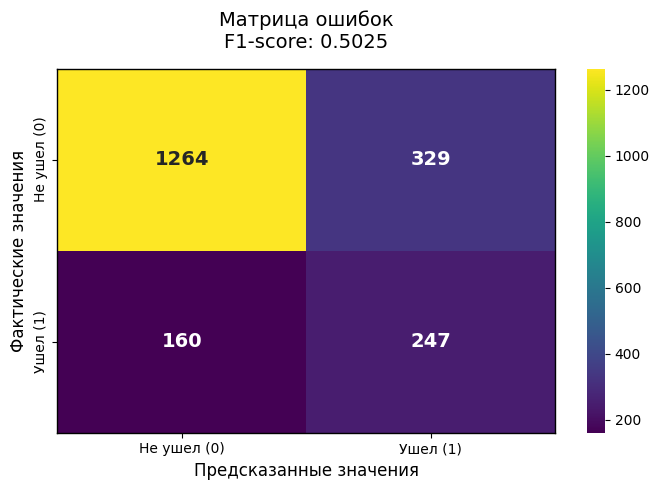

Матрица ошибок:
        Предсказано
       0     1
0    1264   329
1     160   247


In [30]:
cm = confusion_matrix(target_test, predictions)

plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
                      annot_kws={'size': 14, 'weight': 'bold'},
                      xticklabels=['Не ушел (0)', 'Ушел (1)'], 
                      yticklabels=['Не ушел (0)', 'Ушел (1)'])

plt.title(f'Матрица ошибок\nF1-score: {f1:.4f}', fontsize=14, pad=15)
plt.ylabel('Фактические значения', fontsize=12)
plt.xlabel('Предсказанные значения', fontsize=12)

# Добавляем рамку
for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

plt.tight_layout()
plt.show()

print("Матрица ошибок:")
print(f"        Предсказано")
print(f"       0     1")
print(f"0    {cm[0,0]:>4}  {cm[0,1]:>4}")
print(f"1    {cm[1,0]:>4}  {cm[1,1]:>4}")

**Вывод по лабораторной работе:**

Основная цель лабораторной работы - достижение значения F1-score > 0.5 - успешно выполнена. После применения даунсэмплинга с долей 0.35 для мажоритарного класса показатель F1-score увеличился с 0.2292 до 0.5025, что превышает требуемый порог.

**Ключевые изменения после балансировки:**
- Соотношение классов улучшилось с 0.256 до 0.422
- Recall вырос с 0.142 до 0.607, что свидетельствует о значительном улучшении распознавания положительного класса
- Хотя Accuracy снизился с 0.805 до 0.756, это ожидаемо при балансировке несбалансированных данных
- Количество ошибок II рода (False Negative) сократилось с 349 до 160

Метод даунсэмплинга доказал свою эффективность для решения проблемы несбалансированных данных и достижения целевого значения F1-score.

